# Bigrams
Model Smoothing

In [2]:
import torch

In [171]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

## 1. Data Gathering

In [4]:
words = open('data/names.txt', 'r').read().splitlines()

In [5]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

## 2. Data Pre-Processing

In [6]:
START = END = '.'

In [7]:
CHARS = sorted(list(set(''.join(words))) + [START])
CHARS

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [8]:
# string/char to idx
stoi = {char:idx for idx, char in enumerate(CHARS)}
itos = {i:s for s, i in stoi.items()}

In [9]:
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [10]:
itos

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

### 2.1 Generate word to context Matrix for biGrams

#### Smoothing init, with 1 instead of 0 (By default each word has one.

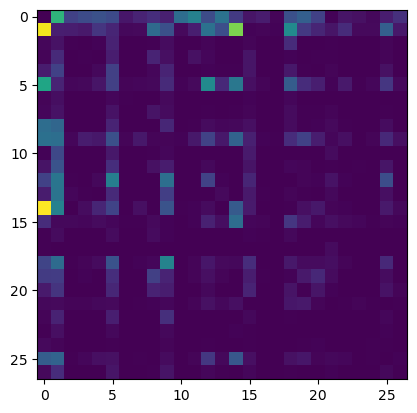

In [14]:
N = torch.ones((len(CHARS), len(CHARS)))

for word in words:
    chars = [START] + list(word) + [END]
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
        
plt.imshow(N)

In [15]:
def plot_matrix(N, float_prec=0):
    plt.figure(figsize=(16, 16))
    plt.imshow(N, cmap='Blues')
    for i in range(len(CHARS)):
        for j in range(len(CHARS)):
            chstr = f"{itos[i]}{itos[j]}"
            plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, f"{N[i, j].item():.{float_prec}f}", ha="center", va="top", color="gray")
    plt.axis('off')

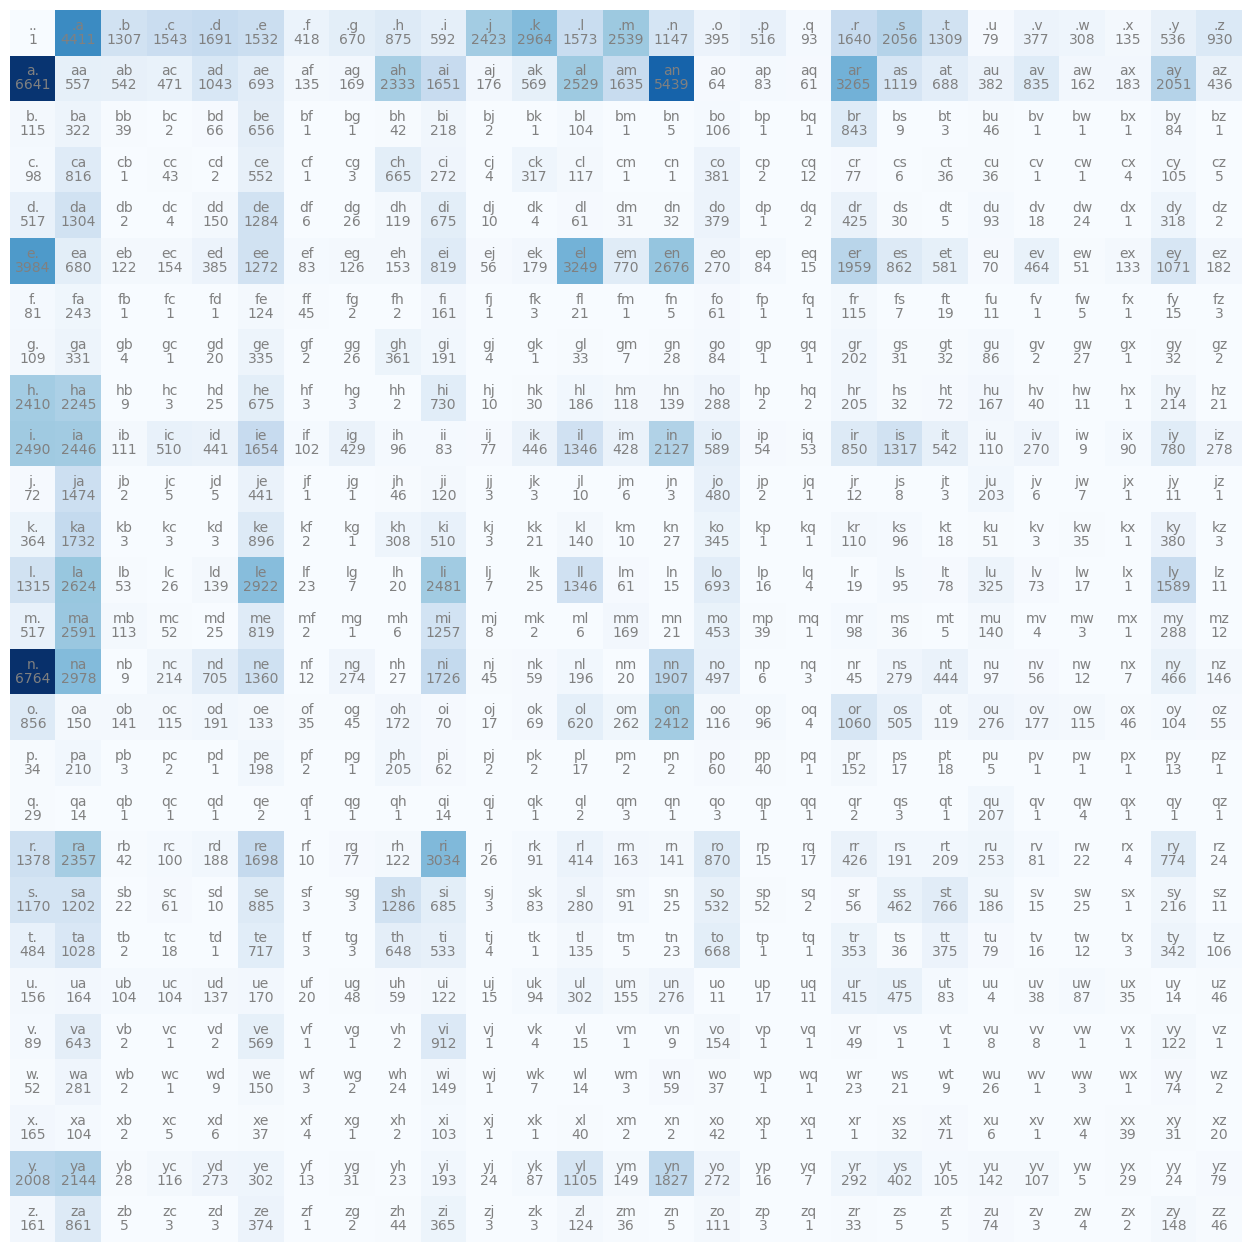

In [16]:
plot_matrix(N=N)

### 2.2 Convert to Probability Matrix

In [17]:
P = N / N.sum(dim=1, keepdims=True)

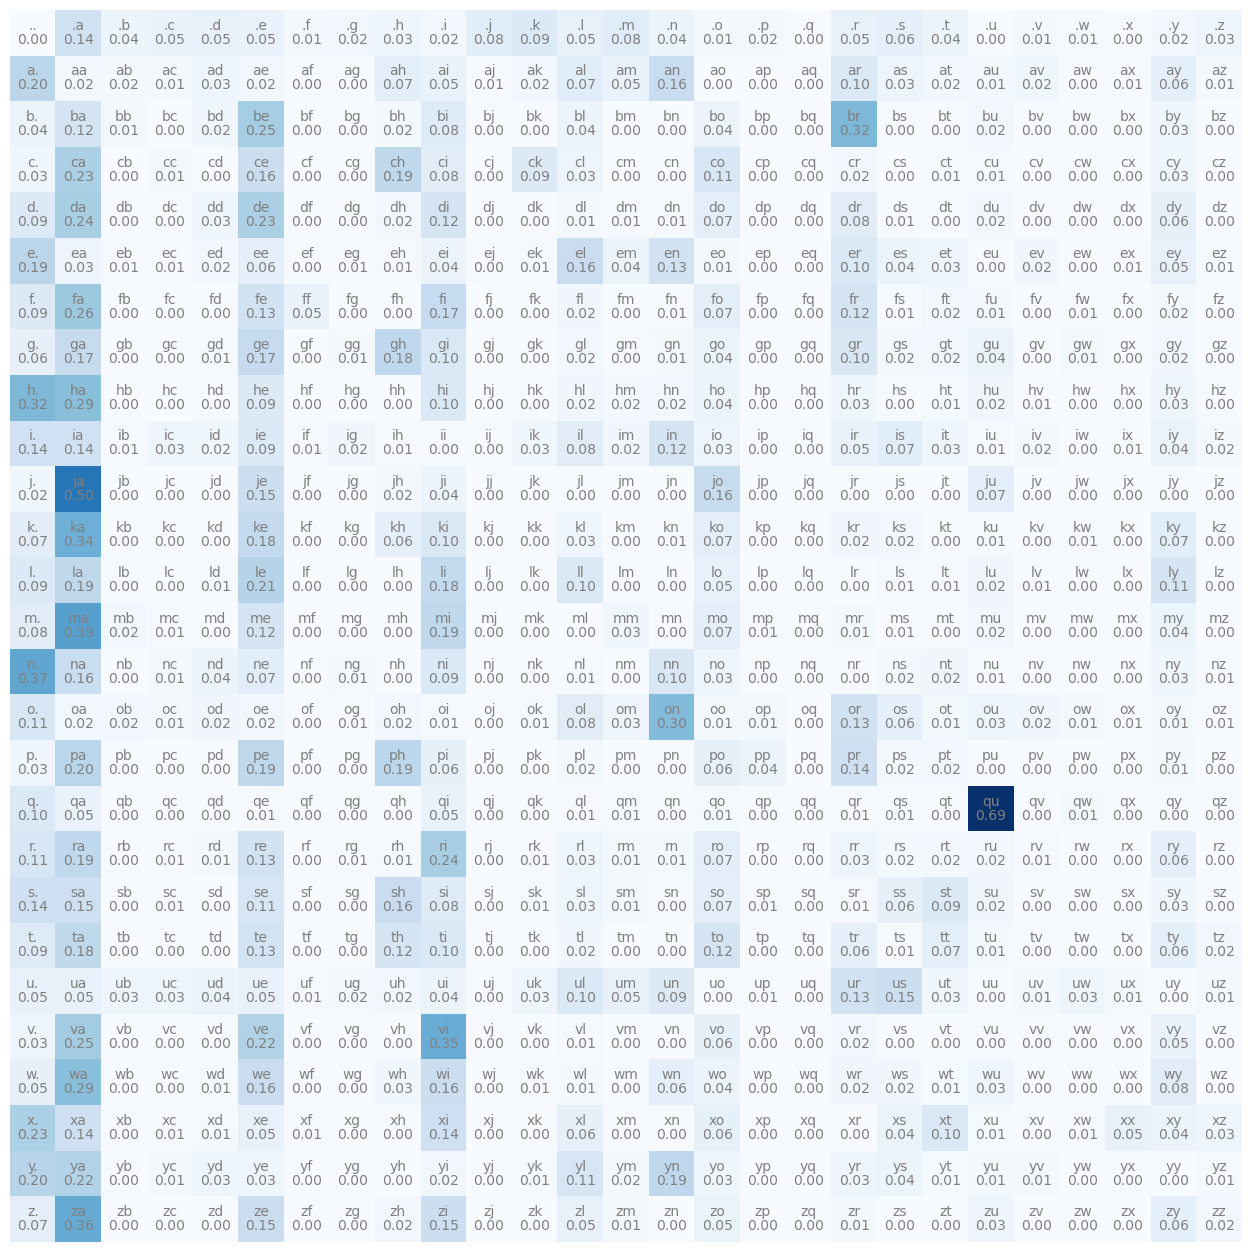

In [18]:
plot_matrix(N=P, float_prec=2)

## 3. Generate next word

In [19]:
P[0]

tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
        1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
        4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
        5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
        4.2109e-03, 1.6719e-02, 2.9008e-02])

In [20]:
# random idx for each word, which results in a random context

g = torch.Generator().manual_seed(4744)
ix = torch.multinomial(P[0], num_samples=1, replacement=True, generator=g).item()

In [21]:
g = torch.Generator().manual_seed(4744)


def gen_word():
    ix = 0
    new_word = ''
    while True:
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        new_word += itos[ix]
        if ix == 0:
            break
    return new_word

gen_word()

'gyushvemin.'

In [22]:
new_words = list()

for i in range(20):
    new_words.append(gen_word())
    
new_words

['ea.',
 'pky.',
 'armye.',
 'sshor.',
 'ka.',
 'e.',
 'aha.',
 'll.',
 'slladelayarta.',
 'jall.',
 'mrayl.',
 'thahe.',
 'dylaaryaloladah.',
 'ariamiziavererilinary.',
 'jsscajeycle.',
 'eeebe.',
 'zalle.',
 'rynn.',
 'bolth.',
 'zeyn.']

## 4. Quality of Model : neg log likelihood

In [23]:
def get_log_likelihood(words, debug=False):
    log_likelihood = 0.0
    n = 0
    for word in words:
        chars = [START] + list(word) + [END]
        for ch1, ch2 in zip(chars, chars[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            p = P[ix1, ix2]
            log_p = torch.log(p)
            if debug: print(f"{ch1}{ch2} {p:.4f} {log_p:.4f}")
            log_likelihood += log_p
            n += 1
            
    print(f"{log_likelihood=}")
    print(f"{-log_likelihood/n=}")
    
    return -log_likelihood/n

In [24]:
nll = get_log_likelihood(words=words)

log_likelihood=tensor(-559951.5625)
-log_likelihood/n=tensor(2.4544)


### 4.1 After smoothing 

In [26]:
nll = get_log_likelihood(words=["mafds"], debug=True)

.m 0.0792 -2.5358
ma 0.3885 -0.9454
af 0.0040 -5.5262
fd 0.0011 -6.8373
ds 0.0054 -5.2155
s. 0.1439 -1.9389
log_likelihood=tensor(-22.9993)
-log_likelihood/n=tensor(3.8332)


## 5. NN Bigram

### 5.1 Training Dataset

In [68]:
xs, ys = list(), list()

for word in words[:]:
    chars = [START] + list(word) + [END]
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        #print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [71]:
xs.shape, ys.shape

(torch.Size([228146]), torch.Size([228146]))

In [72]:
xs[:5], ys[:5]

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

### 5.2 one hot encode

In [73]:
import torch.nn.functional as F

In [74]:
xenc = F.one_hot(xs, num_classes=len(CHARS)).float()
xenc[:5], xenc.shape

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([228146, 27]))

### 5.3 Neurons

#### 5.3.1 Neuron 1

In [75]:
W = torch.randn((len(CHARS), 1))
W, W.shape

(tensor([[ 0.6062],
         [ 1.9654],
         [ 0.6482],
         [ 0.1241],
         [ 0.4189],
         [-0.6000],
         [-0.0424],
         [ 0.0995],
         [ 1.3577],
         [-0.7464],
         [ 1.1887],
         [ 0.5422],
         [-1.2445],
         [ 1.1982],
         [-0.8526],
         [ 0.0574],
         [-0.6268],
         [-1.6837],
         [-0.1240],
         [ 1.7840],
         [ 0.4549],
         [-0.4699],
         [ 0.4403],
         [-0.0102],
         [-0.9283],
         [-0.1892],
         [-0.8174]]),
 torch.Size([27, 1]))

In [76]:
WX = xenc @ W

WX, WX.shape

(tensor([[ 0.6062],
         [-0.6000],
         [ 1.1982],
         ...,
         [-0.1892],
         [-0.8174],
         [-0.9283]]),
 torch.Size([228146, 1]))

#### 5.3.2 Neurons 27

In [77]:
W = torch.randn((len(CHARS), len(CHARS)))
W.shape

torch.Size([27, 27])

In [78]:
WX = xenc @ W

WX.shape

torch.Size([228146, 27])

### 5.4 Neural Net

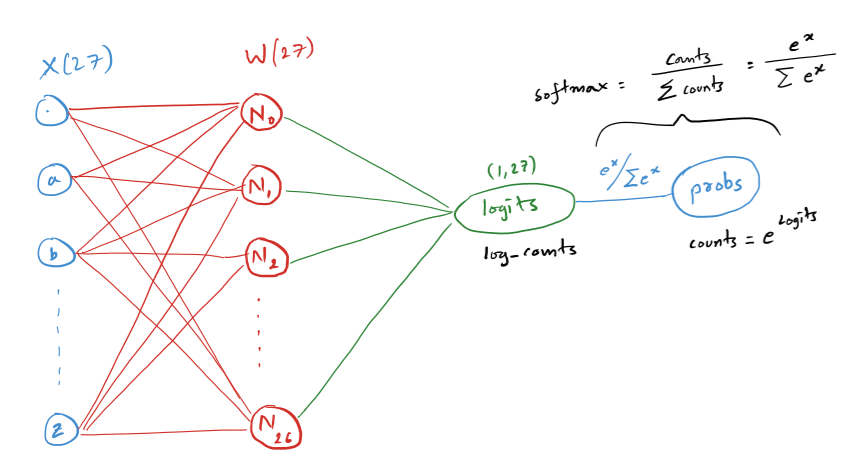

In [86]:
xenc.shape

torch.Size([228146, 27])

In [162]:
# init model weights
W = torch.randn((len(CHARS), len(CHARS)), requires_grad=True)
W.shape

torch.Size([27, 27])

In [163]:
# forward, log_counts
logits = xenc @ W  # logits are log_ccounts
logits.shape

torch.Size([228146, 27])

In [164]:
# counts
counts = torch.exp(logits)
counts.shape

torch.Size([228146, 27])

In [165]:
probs = counts / counts.sum(dim=1, keepdims=True)  # softmax, probability of each row
assert round(probs[0].sum().item(), 0) == 1.
probs.shape

torch.Size([228146, 27])

In [166]:
probs[0].sum().item()

1.0

In [167]:
# Negative log likelihood loss

loss = -probs[torch.arange(probs.shape[0]), ys].log().mean()
loss

tensor(3.7092, grad_fn=<NegBackward0>)

In [168]:
# backward
W.grad = None
loss.backward()

In [169]:
lr = 0.1
# update
W.data += lr * W.grad

#### 5.4.1 Training loop

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Loss 1/100: 3.5895655155181885
Loss 10/100: 2.671921968460083
Loss 20/100: 2.5758144855499268
Loss 30/100: 2.538642406463623
Loss 40/100: 2.5197789669036865
Loss 50/100: 2.5091307163238525
Loss 60/100: 2.5024404525756836
Loss 70/100: 2.497882843017578
Loss 80/100: 2.494607925415039
Loss 90/100: 2.492164373397827
Loss 100/100: 2.4902889728546143


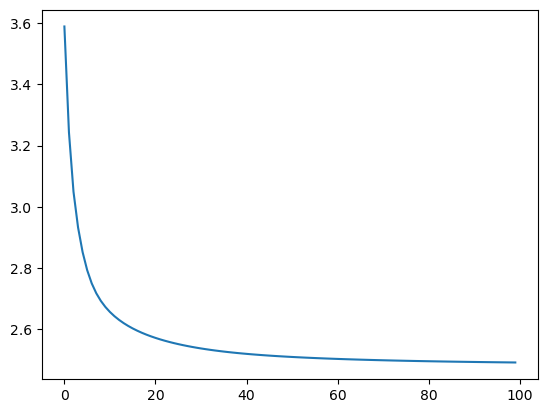

In [187]:
epochs = 100
lr = 50
rr = 0.01 # Regularisation rate

W = torch.randn((len(CHARS), len(CHARS)), requires_grad=True)


losses = list()
for epoch in tqdm(range(epochs), desc="Epochs"):
    # forward : linear layer
    logits = xenc @ W       # logits are log_counts
    
    # softmax
    counts = torch.exp(logits)
    probs = counts / counts.sum(dim=1, keepdims=True)
    
    # loss: negative log liklihood
    loss = -probs[torch.arange(probs.shape[0]), ys].log().mean() + rr*(W**2).mean()
    if epoch in {0} or epoch % 10 == 9: print(f"Loss {epoch+1}/{epochs}: {loss.item()}")
    losses.append(loss.item())
    
    # Backward
    W.grad = None
    loss.backward()
    
    # optimize
    W.data -= lr * W.grad
    
plt.plot(losses)

#### 5.4.2 Prediction

In [204]:
# old probabilisic model

g = torch.Generator().manual_seed(4744)
new_words = list()

for i in range(20):
    new_words.append(gen_word())
    
new_words

['gyushvemin.',
 'ea.',
 'pky.',
 'armye.',
 'sshor.',
 'ka.',
 'e.',
 'aha.',
 'll.',
 'slladelayarta.',
 'jall.',
 'mrayl.',
 'thahe.',
 'dylaaryaloladah.',
 'ariamiziavererilinary.',
 'jsscajeycle.',
 'eeebe.',
 'zalle.',
 'rynn.',
 'bolth.']

In [207]:
g = torch.Generator().manual_seed(4744)


def gen_word_nn():
    ix = 0
    new_word = ''
    while True:
        _xenc = F.one_hot(torch.tensor([ix]), num_classes=len(CHARS)).float()
        logits = _xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdims=True)
        
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        new_word += itos[ix]
        if ix == 0:
            break
    return new_word

gen_word_nn()

'gzyriyanin.'

In [208]:
g = torch.Generator().manual_seed(4744)
new_words = list()

for i in range(20):
    new_words.append(gen_word_nn())
    
new_words

['gzyriyanin.',
 'ea.',
 'pova.',
 'sowfatriss.',
 'ka.',
 'e.',
 'aha.',
 'll.',
 'slladelayarta.',
 'jall.',
 'mrayl.',
 'thahe.',
 'dylaaryaloladah.',
 'ariamiziavererilinary.',
 'jusdajeycon.',
 'eeece.',
 'zalle.',
 'rzos.',
 'bqmon.',
 'zeyn.']